In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

dataset = "brightkite"

DATASET_DIR = f"/Volumes/Forster Neu/Masterarbeit Data/{dataset}_dataset/"

#DATASET_DIR = f"/Volumes/Forster Neu/Masterarbeit Data/snowcard/TSC_EEL_EXPORT.csv"


In [14]:
#businesses = pd.read_csv(GOWALLA_DIR + "processed_data_cornac/businesses.csv")
user_events = pd.read_csv(DATASET_DIR  + "processed_data_cornac/user_events.csv")
high_pop_users = pd.read_csv(DATASET_DIR  + "processed_data_cornac/high_pop_user_sample.csv")
med_pop_users = pd.read_csv(DATASET_DIR + "processed_data_cornac/medium_pop_user_sample.csv")
low_pop_users = pd.read_csv(DATASET_DIR  + "processed_data_cornac/low_pop_user_sample.csv")


# user_events = pd.read_csv(DATASET_DIR, encoding="latin1", sep=";", header=None, names=["timestamp", "user_id", "region_id", "region_name", "business_id", "card_type"])

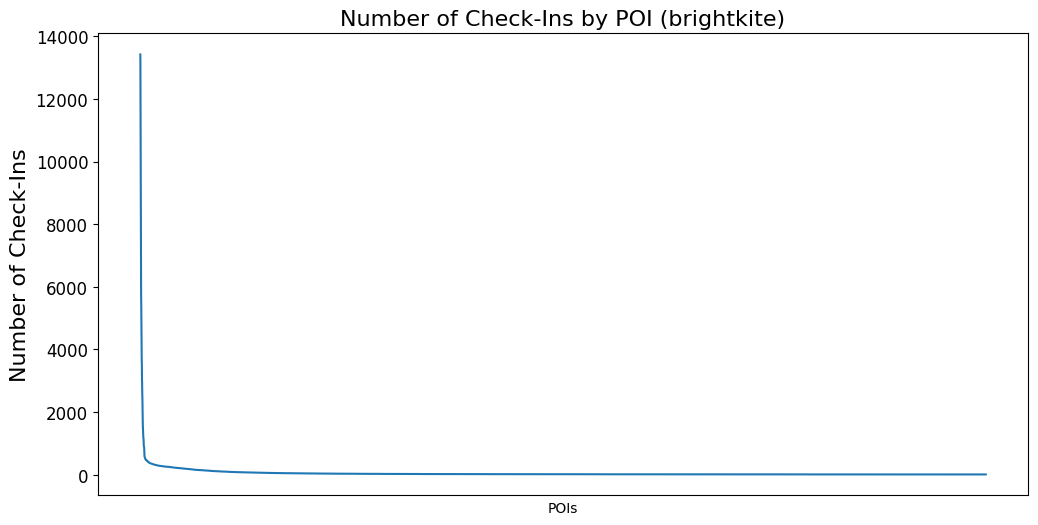

In [15]:
user_events["business_id"].astype(str).value_counts().plot(figsize=(12, 6), linestyle='-')

# Customizing the plot
plt.xlabel('POIs')  # Remove x-axis label
plt.title(f'Number of Check-Ins by POI ({dataset})', fontsize=16)  # Add a header with a specified font size
plt.ylabel('Number of Check-Ins', fontsize=16)  # Customize the y-axis label with a specified font size
plt.grid(False)  # Add a grid for better readability

# Remove x-axis ticks
plt.xticks([])

# Set y-axis labels font size
plt.yticks(fontsize=12)  



plt.savefig(f'{DATASET_DIR}/plots/Number of Check-Ins by POI ({dataset})', dpi=300)
#plt.savefig(f'/Volumes/Forster Neu/Masterarbeit Data/snowcard/plots/Number of Check-Ins by REGION ({dataset})', dpi=300)



In [16]:
# user distribution
user_dist = user_events["user_id"].value_counts()
num_users = user_dist.shape[0]
print("Mean POI check-ins per User: ", user_events["user_id"].value_counts().mean())
print("Min POI check-ins per User: ", user_events["user_id"].value_counts().min())
print("Max POI check-ins per User: ", user_events["user_id"].value_counts().max())
print("Number of users: ", num_users)

# item distribution
item_dist = user_events["business_id"].value_counts()
num_items = item_dist.shape[0]
print("Number of POIs (items): ", num_items)

# sparsity
print("Sparsity:", 1 - len(user_events) / (len(user_events["user_id"].unique()) * len(user_events["business_id"].unique())))


Mean POI check-ins per User:  131.64064731080438
Min POI check-ins per User:  10
Max POI check-ins per User:  2100
Number of users:  4202
Number of POIs (items):  9429
Sparsity: 0.9860387477663799


In [17]:
len(user_events["user_id"].unique())

4202

In [18]:
user_events["business_id"].value_counts()

business_id
ee81ef22a22411ddb5e97f082c799f59            13418
ee8b1d0ea22411ddb074dbd65f1665cf            13239
ee78cc1ca22411dd9b3d576115a846a7            12175
ecceeae0a22411dd831d5f56beef969a             9808
eefadd1aa22411ddb0fd7f1c9c809c0c             9626
                                            ...  
363d30daca5a11dd85ea003048c0801e               10
58aba8081fc411de9f61003048c0801e               10
ede3ec3ca22411ddbe371346e6abfb10               10
f75475775cd246c79b12f6679466cfb7fa9aada2       10
d57f0bf039fe117c6c1a85efd6947b2ce33efa03       10
Name: count, Length: 9429, dtype: int64

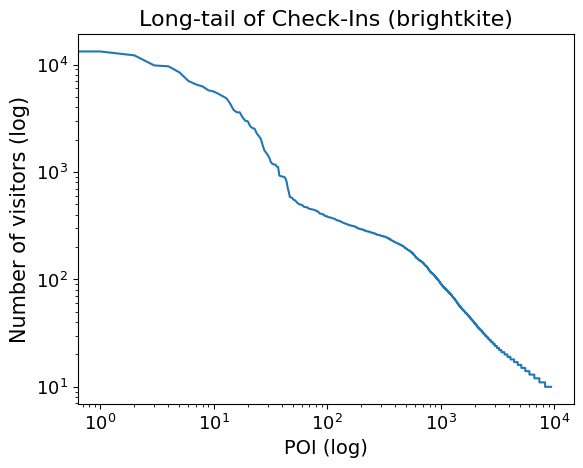

In [19]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values, linestyle='-')
plt.title(f'Long-tail of Check-Ins ({dataset})', fontsize=16)
plt.xlabel('POI (log)', fontsize=14)
plt.ylabel('Number of visitors (log)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig(f'{DATASET_DIR}/plots/Long-tail of Check-Ins ({dataset})', dpi=300)
# plt.savefig('/Volumes/Forster Neu/Masterarbeit Data/snowcard/Long-tail of Check-Ins ({dataset})', dpi=300)


plt.show()


#### Recreating the popularity calculation from: https://github.com/domkowald/FairRecSys/blob/master/LFM_Fairness.ipynb

In [20]:
top_fraction = 0.2
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
no_users = len(high_pop_users) + len(med_pop_users) + len(low_pop_users)
# no_users = len(user_events["user_id"].unique())

In [21]:
# Initialize lists and counters
pop_count = []
user_hist = []
pop_fraq = []
pop_item_fraq = []
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0

# Iterate through each user and calculate detailed metrics
for u, df in user_events.groupby('user_id'):
    no_user_items = len(set(df["business_id"]))  # Profile size
    no_user_pop_items = len(set(df["business_id"]) & set(top_item_dist.index))  # Top items in profile
    
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    
    # Calculate the average popularity of items in the user's profile
    user_pop_item_fraq = sum(item_dist[df["business_id"]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    
    # Update group-specific values
    if u in low_pop_users['user_id'].values:
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in med_pop_users['user_id'].values:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    elif u in high_pop_users['user_id'].values:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1

# Calculate average values for each user group (avoid division by zero)
if len(low_pop_users) > 0:
    low_profile_size /= len(low_pop_users)
    low_gap /= len(low_pop_users)
if len(med_pop_users) > 0:
    medium_profile_size /= len(med_pop_users)
    medium_gap /= len(med_pop_users)
if len(high_pop_users) > 0:
    high_profile_size /= len(high_pop_users)
    high_gap /= len(high_pop_users)

# Print results for verification
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))
# average number of unique POIs that users interact with in each popularity group
print('Low profile size: ' + str(low_profile_size))
print('Medium profile size: ' + str(medium_profile_size))
print('High profile size: ' + str(high_profile_size))
print('Low gap: ' + str(low_gap))
print('Medium gap: ' + str(medium_gap))
print('High gap: ' + str(high_gap))

Low count (for check): 1438
Med count (for check): 1367
High count (for check): 1397
Low profile size: 1.542
Medium profile size: 8.674666666666667
High profile size: 6.157333333333334
Low gap: 0.03944622839506194
Medium gap: 1.3241521881143696
High gap: 76.61459042986326


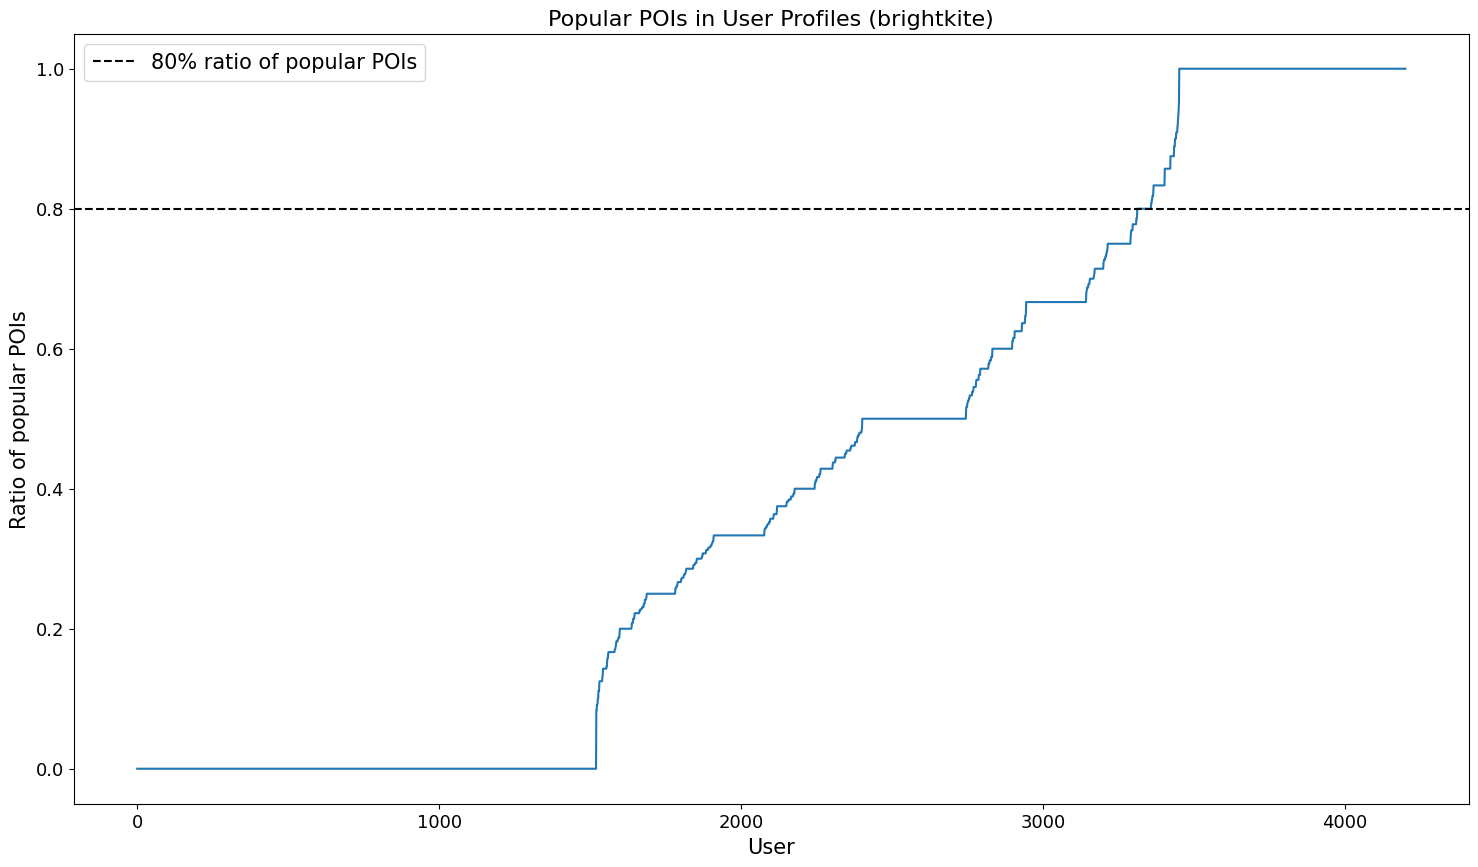

In [22]:
sorted_pop_fraq = sorted(pop_fraq)
plt.figure(figsize=(18, 10))  # Adjust the figure size if needed
plt.plot(sorted_pop_fraq, linestyle='-')
plt.title(f'Popular POIs in User Profiles ({dataset})', fontsize=16)
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular POIs', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular POIs')
plt.legend(fontsize='15')

plt.savefig(f'{DATASET_DIR}/plots/Popular POIs in User Profiles ({dataset})', dpi=300)
# plt.savefig('/Volumes/Forster Neu/Masterarbeit Data/snowcard/Popular POIs in User Profiles ({dataset})', dpi=300)


plt.show()

R-value: 0.865548010968201
P-value: 0.0


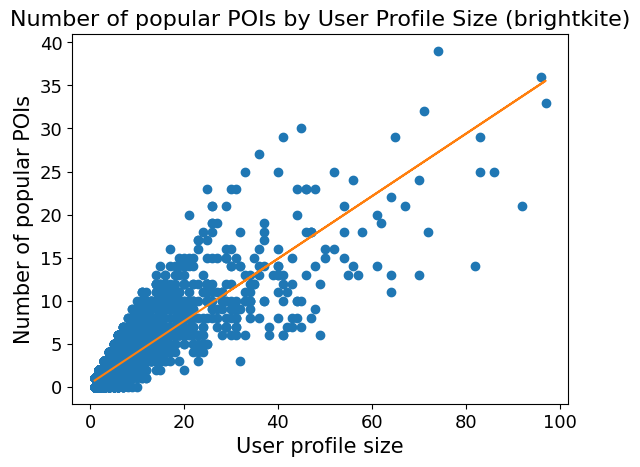

In [23]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
print('P-value: ' + str(p_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.title(f'Number of popular POIs by User Profile Size ({dataset})', fontsize=16) 
plt.xlabel('User profile size', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular POIs', fontsize='15')
plt.yticks(fontsize='13')
plt.savefig(f'{DATASET_DIR}/plots/Number of popular POIs by User Profile Size ({dataset})', dpi=300)
# plt.savefig('/Volumes/Forster Neu/Masterarbeit Data/snowcard/Number of popular POIs by User Profile Size', dpi=300)


R-value: -0.0517750972622987
SignificanceResult(statistic=0.2729911857481158, pvalue=1.0459713673748207e-72)


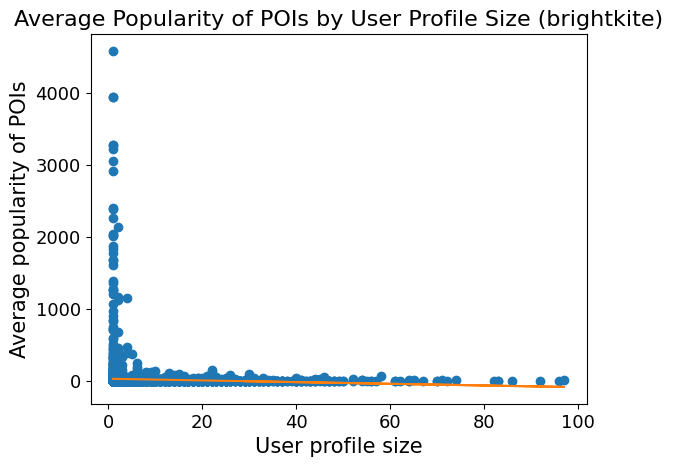

In [24]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.title(f'Average Popularity of POIs by User Profile Size ({dataset})', fontsize=16) 
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of POIs', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')

plt.savefig(f'{DATASET_DIR}/plots/Average Popularity of POIs by User Profile Size ({dataset})', dpi=300)
# plt.savefig(f'/Volumes/Forster Neu/Masterarbeit Data/snowcard/Average Popularity of POIs by User Profile Size ({dataset})', dpi=300)
